In [1]:
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import beta
from scipy.integrate import trapezoid
from numpy.random import Generator, PCG64

# Set initial seed for random sampling
beta.random_state = Generator(PCG64(seed=5731))

# Morphology Data

---

In [2]:
morpho = fits.open('manga_visual_morpho-2.0.1.fits')
morpho_data = morpho[1].data
morpho[1].columns

ColDefs(
    name = 'Name'; format = '17A'
    name = 'plateifu'; format = '11A'
    name = 'MANGAID'; format = '9A'
    name = 'objra'; format = 'D'
    name = 'objdec'; format = 'D'
    name = 'Type'; format = '11A'
    name = 'TType'; format = 'I'; null = -32768
    name = 'Unsure'; format = 'I'; null = -32768
    name = 'Bars'; format = 'E'
    name = 'Edge_on'; format = 'I'; null = -32768
    name = 'Tidal'; format = 'I'; null = -32768
    name = 'C'; format = 'E'
    name = 'E_C'; format = 'E'
    name = 'A'; format = 'E'
    name = 'E_A'; format = 'E'
    name = 'S'; format = 'E'
    name = 'E_S'; format = 'E'
    name = 'cas_flag'; format = 'J'; null = -2147483648
)

In [3]:
# group galaxies according to their types

np.unique(morpho_data['Type'])

chararray(['BCD', 'E', 'E(dSph)', 'E+E', 'Edc', 'Irr', 'IrrAB', 'IrrB',
           'S', 'S-merger', 'S0', 'S0(dwarf)', 'S0a', 'SAB', 'SAB-merger',
           'SAB0', 'SAB0a', 'SABa', 'SABab', 'SABb', 'SABbc', 'SABc',
           'SABcd', 'SABd', 'SABdm', 'SABm', 'SB0', 'SB0a', 'SBa', 'SBab',
           'SBb', 'SBbc', 'SBc', 'SBcd', 'SBd', 'SBdm', 'SBm', 'Sa',
           'Sab', 'Sb', 'Sbc', 'Sc', 'Scd', 'Sd', 'Sdm', 'Sm', 'dIrr',
           'dSph', 'dwarf', 'interacting'], dtype='<U11')

In [4]:
# VERY IMPORTANT: GET RID OF REDUNDANT CHARACTERS!!!
types = np.char.strip(morpho_data['Type'])

early_types = ['E', 'E(dSph)', 'E+E', 'Edc', 'S0', 'S0a', 'S0(dwarf)', 'SAB0', 'SB0', 'SB0a', 'dSph']
late_types = ['Sa', 'Sb', 'Sbc', 'Sc', 'Sd', 'Sm', 'Sab', 'Sbc', 'Scd', 'SAB', 'SABa', 'SABb', 'SABbc', 'SABcd',
              'SBa', 'SBb', 'SBbc', 'SBcd', 'SBdm', 'SBm', 'S-merger', 'Irr', 'IrrAB', 'IrrB', 'dIrr', 'BCD', 'dwarf']

early_mask = np.isin(types, early_types)
early_galaxies = morpho_data[early_mask]

late_mask = np.isin(types, late_types)
late_galaxies = morpho_data[late_mask]

print(f"Number of early-type galaxies: {len(early_galaxies)}")
print(f"Number of late-type galaxies: {len(late_galaxies)}")
print(f'Number of all galaxies: {len(morpho_data)}')

Number of early-type galaxies: 3626
Number of late-type galaxies: 4975
Number of all galaxies: 10126


In [5]:
early_galaxies['Name']

chararray(['manga-10001-1902', 'manga-10001-3701', 'manga-10001-3702',
           ..., 'manga-9894-1901', 'manga-9894-3704', 'manga-9894-9101'],
          dtype='<U17')

# AGN Data

---

In [6]:
agn = fits.open('manga_agn-v2_0_1.fits')
agn_data = agn[1].data
agn[1].columns

ColDefs(
    name = 'MANGAID'; format = '17A'
    name = 'RA'; format = 'E'
    name = 'DEC'; format = 'E'
    name = 'Z'; format = 'E'
    name = 'WISE_AGN'; format = 'I'
    name = 'LOG_LBOL_WISE'; format = 'E'
    name = 'LOG_LBOL_WISE_ERR'; format = 'E'
    name = 'BAT_AGN'; format = 'I'
    name = 'LOG_LBOL_BAT'; format = 'E'
    name = 'LOG_LBOL_BAT_ERR'; format = 'E'
    name = 'RADIO_AGN'; format = 'I'
    name = 'LOG_LBOL_RADIO'; format = 'E'
    name = 'LOG_LBOL_RADIO_ERR'; format = 'E'
    name = 'RADIO_CLASS'; format = '4A'
    name = 'BROAD_AGN'; format = 'I'
    name = 'LOG_LBOL_BROAD'; format = 'E'
    name = 'LOG_LBOL_BROAD_ERR'; format = 'E'
)

In [7]:
# group AGN data according to the hosting galaxy types

early_mask = np.isin(agn_data['MANGAID'], early_galaxies['Name'])
agn_early = agn_data[early_mask]

late_mask = np.isin(agn_data['MANGAID'], late_galaxies['Name'])
agn_late = agn_data[late_mask]

print(f"Number of early-type galaxies with AGNs: {len(agn_early)}")
print(f"Number of late-type galaxies with AGNs: {len(agn_late)}")

Number of early-type galaxies with AGNs: 236
Number of late-type galaxies with AGNs: 112


# Plots

---

In [8]:
def prior(theta, a, b):
    return beta.pdf(theta, a, b)

def strl_approx(n):
    return (n*np.log(n) - n + np.log(np.pi)/2 +
            np.log(8*n**3 + 4*n**2 + n + 1/30)/6)

def likelihood(x, theta, n):
    log_comb = strl_approx(n) - strl_approx(x) - strl_approx(n - x)
    return np.exp(log_comb + x*np.log(theta) + (n-x)*np.log(1 - theta))

def posterior(theta, x, n, a, b):
    post_dist = likelihood(x, theta, n) * prior(theta, a, b)
    evidence = trapezoid(post_dist, theta)
    return post_dist / evidence

def prior_predictive(x, theta, n, a, b):
    return trapezoid(likelihood(x[:, None], theta, n) * prior(theta, a, b), theta)

def post_predictive(x, X, theta, n, a, b):
    return trapezoid(likelihood(x[:, None], theta, n) * posterior(theta, X, n, a, b), theta)

def weighted_quantile(data, weights, q):
    cdf = (np.cumsum(weights) - 0.5*weights) / np.sum(weights)
    return np.interp(q, cdf, data)

posterior max: 0.0654
95% credible interval: (0.0575, 0.0736)


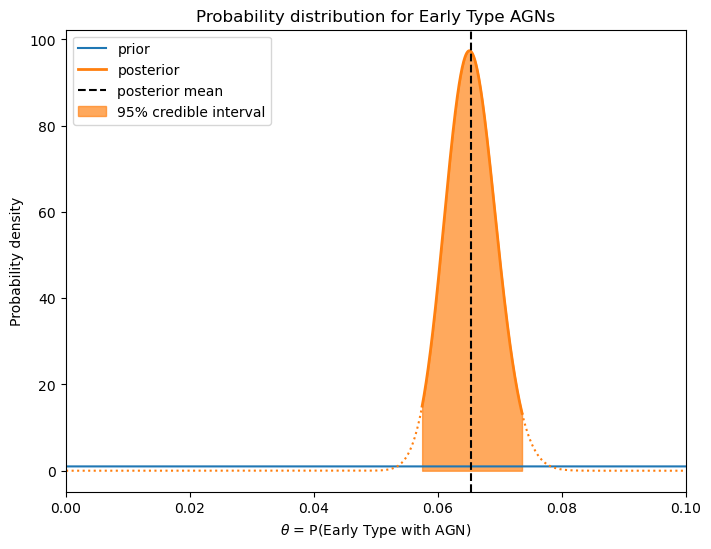

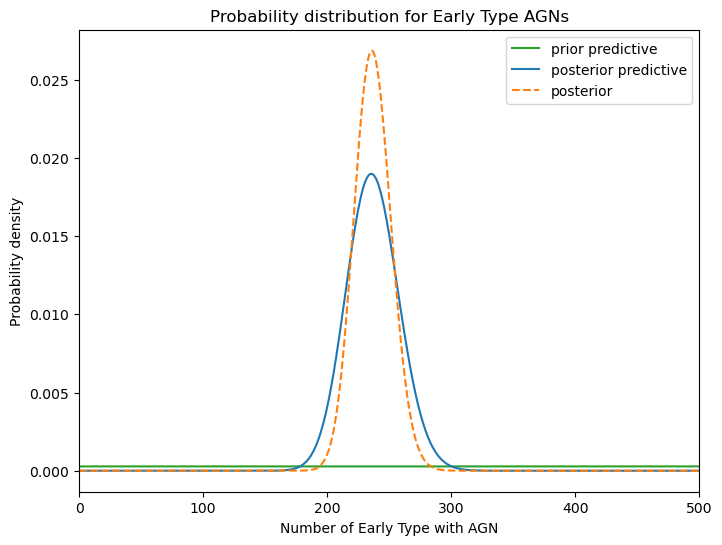

In [9]:
# Sample theta from uniform distribution and compute posterior
N_samples = 100000
a, b = 1, 1 # 24, 1000
theta = np.sort(beta.rvs(a, b, size=N_samples))
n = early_galaxies.shape[-1]
x = agn_early.shape[-1]
post_dist = posterior(theta, x, n, a, b)

# Set up credible interval
q_lv = weighted_quantile(theta, post_dist, 0.025)
q_uv = weighted_quantile(theta, post_dist, 0.975)
lv_ind = np.argmin(theta < q_lv) + 1
uv_ind = np.argmax(theta > q_uv) - 1
mid_inds = np.logical_and(theta > q_lv, theta < q_uv)

# Compute posterior maximum and 95% credible interval
mean_theta = np.sum(theta*post_dist) / np.sum(post_dist)
print(f'posterior max: {mean_theta:.4f}')
print(f'95% credible interval: ({theta[lv_ind]:.4f}, {theta[uv_ind]:.4f})')

# Plot posterior distribution
plt.figure(figsize=(8, 6))
plt.plot(theta, prior(theta, a, b), label='prior')
plt.plot(theta[mid_inds], post_dist[mid_inds],
         linewidth=2, color='C1', label='posterior')
plt.plot(theta[:lv_ind+1], post_dist[:lv_ind+1],
         linestyle=':', linewidth=1.5, color='C1')
plt.plot(theta[uv_ind-1:], post_dist[uv_ind-1:],
         linestyle=':', linewidth=1.5, color='C1')
plt.axvline(mean_theta, color='k', linestyle='--', label='posterior mean')
plt.fill_between(theta[mid_inds], post_dist[mid_inds], alpha=0.67,
                 label='95% credible interval', color='C1')
plt.title('Probability distribution for Early Type AGNs')
plt.xlabel(r'$\theta$ = P(Early Type with AGN)')
plt.ylabel('Probability density')
plt.xlim(0.0, 0.1)
plt.legend()
# plt.savefig('Early_Type_Posterior.png')
plt.show()

x_cutoff = 500
x_new = np.arange(1, x_cutoff)
plt.figure(figsize=(8, 6))
plt.plot(x_new, prior_predictive(x_new, theta, n, a, b), label='prior predictive', color='C2')
plt.plot(x_new, post_predictive(x_new, x, theta, n, a, b), label='posterior predictive', color='C0')
plt.plot(theta*n, post_dist/trapezoid(post_dist, theta*n), label='posterior', linestyle='--', color='C1')
plt.title('Probability distribution for Early Type AGNs')
plt.xlabel('Number of Early Type with AGN')
plt.ylabel('Probability density')
plt.xlim(0, x_cutoff)
plt.legend()
# plt.savefig('Early_Type_Predicative.png')
plt.show()

posterior max: 0.0228
95% credible interval: (0.0188, 0.0270)


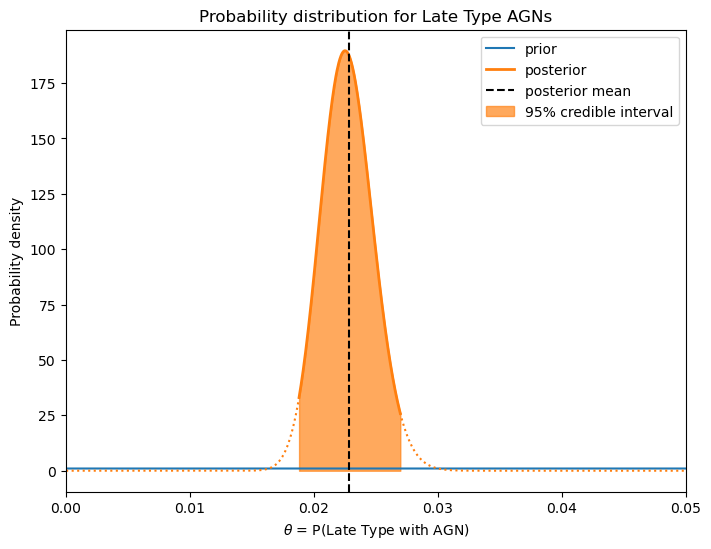

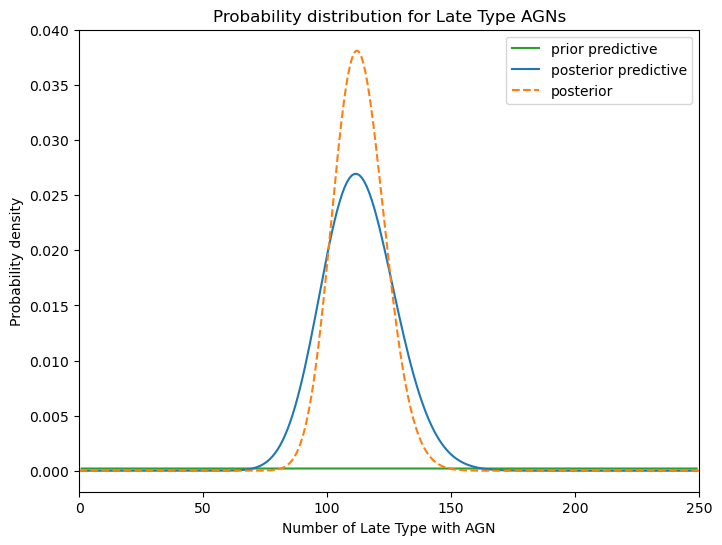

In [10]:
# Sample theta from uniform distribution and compute posterior
N_samples = 100000
a, b = 1, 1 # 3, 100
theta = np.sort(beta.rvs(a, b, size=N_samples))
n = late_galaxies.shape[-1]
x = agn_late.shape[-1]
post_dist = posterior(theta, x, n, a, b)

# Set up credible interval
q_lv = weighted_quantile(theta, post_dist, 0.025)
q_uv = weighted_quantile(theta, post_dist, 0.975)
lv_ind = np.argmin(theta < q_lv) + 1
uv_ind = np.argmax(theta > q_uv) - 1
mid_inds = np.logical_and(theta > q_lv, theta < q_uv)

# Compute posterior mean and 95% credible interval
mean_theta = np.sum(theta*post_dist) / np.sum(post_dist)
print(f'posterior max: {mean_theta:.4f}')
print(f'95% credible interval: ({theta[lv_ind]:.4f}, {theta[uv_ind]:.4f})')

# Plot posterior distribution
plt.figure(figsize=(8, 6))
plt.plot(theta, prior(theta, a, b), label='prior')
plt.plot(theta[mid_inds], post_dist[mid_inds],
         linewidth=2, color='C1', label='posterior')
plt.plot(theta[:lv_ind+1], post_dist[:lv_ind+1],
         linestyle=':', linewidth=1.5, color='C1')
plt.plot(theta[uv_ind-1:], post_dist[uv_ind-1:],
         linestyle=':', linewidth=1.5, color='C1')
plt.axvline(mean_theta, color='k', linestyle='--', label='posterior mean')
plt.fill_between(theta[mid_inds], post_dist[mid_inds], alpha=0.67,
                 label='95% credible interval', color='C1')
plt.title('Probability distribution for Late Type AGNs')
plt.xlabel(r'$\theta$ = P(Late Type with AGN)')
plt.ylabel('Probability density')
plt.xlim(0.0, 0.05)
plt.legend()
# plt.savefig('Late_Type_Posterior.png')
plt.show()


x_cutoff = 250
x_new = np.arange(1, x_cutoff)
plt.figure(figsize=(8, 6))
plt.plot(x_new, prior_predictive(x_new, theta, n, a, b), label='prior predictive', color='C2')
plt.plot(x_new, post_predictive(x_new, x, theta, n, a, b), label='posterior predictive', color='C0')
plt.plot(theta*n, post_dist/trapezoid(post_dist, theta*n), label='posterior', linestyle='--', color='C1')
plt.title('Probability distribution for Late Type AGNs')
plt.xlabel('Number of Late Type with AGN')
plt.ylabel('Probability density')
plt.xlim(0, x_cutoff)
plt.legend()
# plt.savefig('Late_Type_Predicative.png')
plt.show()

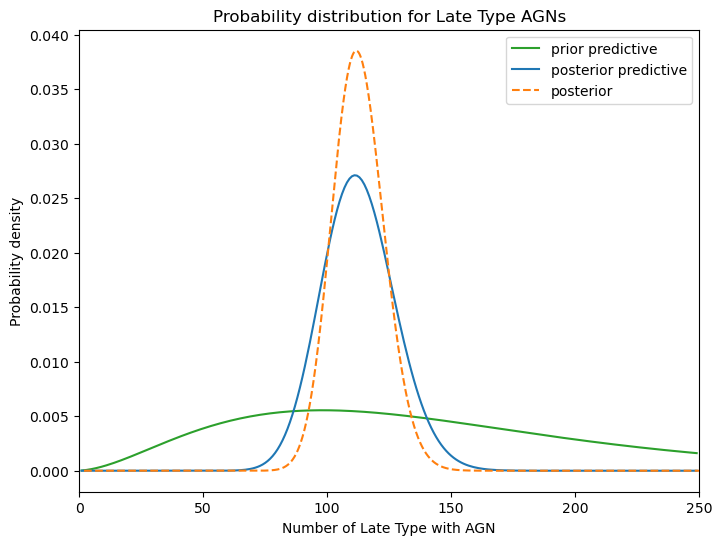

In [12]:
# Sample theta from uniform distribution and compute posterior
N_samples = 100000
a, b = 3, 100
theta = np.sort(beta.rvs(a, b, size=N_samples))
n = late_galaxies.shape[-1]
x = agn_late.shape[-1]
post_dist = posterior(theta, x, n, a, b)


x_cutoff = 250
x_new = np.arange(1, x_cutoff)
plt.figure(figsize=(8, 6))
plt.plot(x_new, prior_predictive(x_new, theta, n, a, b), label='prior predictive', color='C2')
plt.plot(theta*n, post_dist/trapezoid(post_dist, theta*n), label='posterior', linestyle='--', color='C1')
plt.plot(x_new, post_predictive(x_new, x, theta, n, a, b), label='posterior predictive', color='C0')
plt.title('Probability distribution for Late Type AGNs')
plt.xlabel('Number of Late Type with AGN')
plt.ylabel('Probability density')
plt.xlim(0, x_cutoff)
plt.legend()
plt.show()